<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/experimental/Kalman_Filters_for_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

In [105]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

[*********************100%***********************]  1 of 1 completed


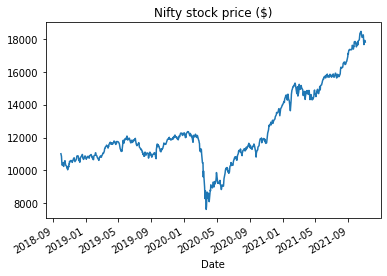

In [127]:
nifty_df = yf.download('^nsei',start='2018-10-01')
nifty_df['Adj Close'].plot(title='Nifty stock price ($)');


In [128]:
#nifty_df = yf.download('sbin.ns',start='2014-01-01',progress=False)


In [129]:
df = nifty_df[['Adj Close']]


mean 15860.666303895248


Text(0.5, 0, 'Days')

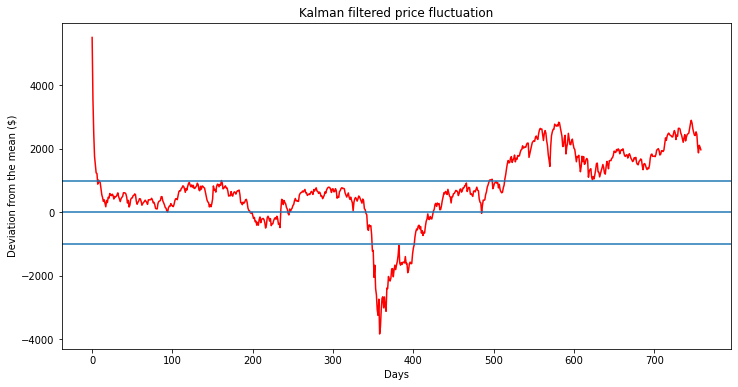

In [130]:
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.0001)
mean, cov = f.filter(df['Adj Close'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
print(f'mean {mean[-1]}')

plt.figure(figsize=(12,6))
plt.plot(df['Adj Close'].values - mean, 'red', lw=1.5)

plt.axhline(y=0)
plt.axhline(y=1000)
plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation")
plt.ylabel("Deviation from the mean ($)")
plt.xlabel("Days")

In [131]:
nifty =pd.DataFrame({'Date': nifty_df.index,'Close':df['Adj Close'].values - mean})


In [132]:
nifty['30 Day MA'] = nifty['Close'].rolling(window=20).mean()
# set .std(ddof=0) for population std instead of sample
nifty['30 Day STD'] = nifty['Close'].rolling(window=20).std() 
nifty['Upper Band'] = nifty['30 Day MA'] + (nifty['30 Day STD'] *0.5)
nifty['Lower Band'] = nifty['30 Day MA'] - (nifty['30 Day STD'] *0.5)

nifty.ta.macd(fast=26,slow=50,signal=18, append=True)

print()

In [133]:
nifty=nifty.set_index('date')

In [134]:
nifty.tail(2)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_26_50_18,MACDh_26_50_18,MACDs_26_50_18
date,,,,,,,,
2021-11-02,2048.066927,2434.859617,263.565358,2566.642296,2303.076938,61.444287,-65.723861,127.168148
2021-11-03,1968.532915,2410.973935,283.380688,2552.664279,2269.283591,45.304833,-73.246123,118.550957


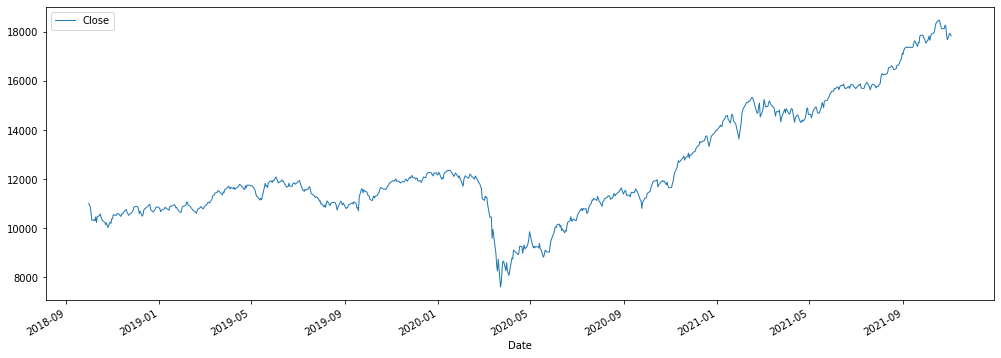

In [135]:
nifty_df[['Close']][-1000:].plot(figsize=(17,6),linewidth=1);

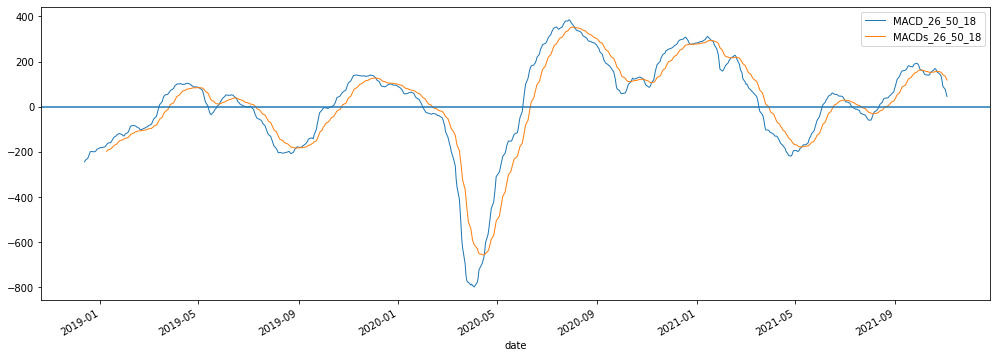

In [136]:
nifty[['MACD_26_50_18','MACDs_26_50_18']][-1000:].plot(figsize=(17,6),linewidth=1);
plt.axhline(y=0);

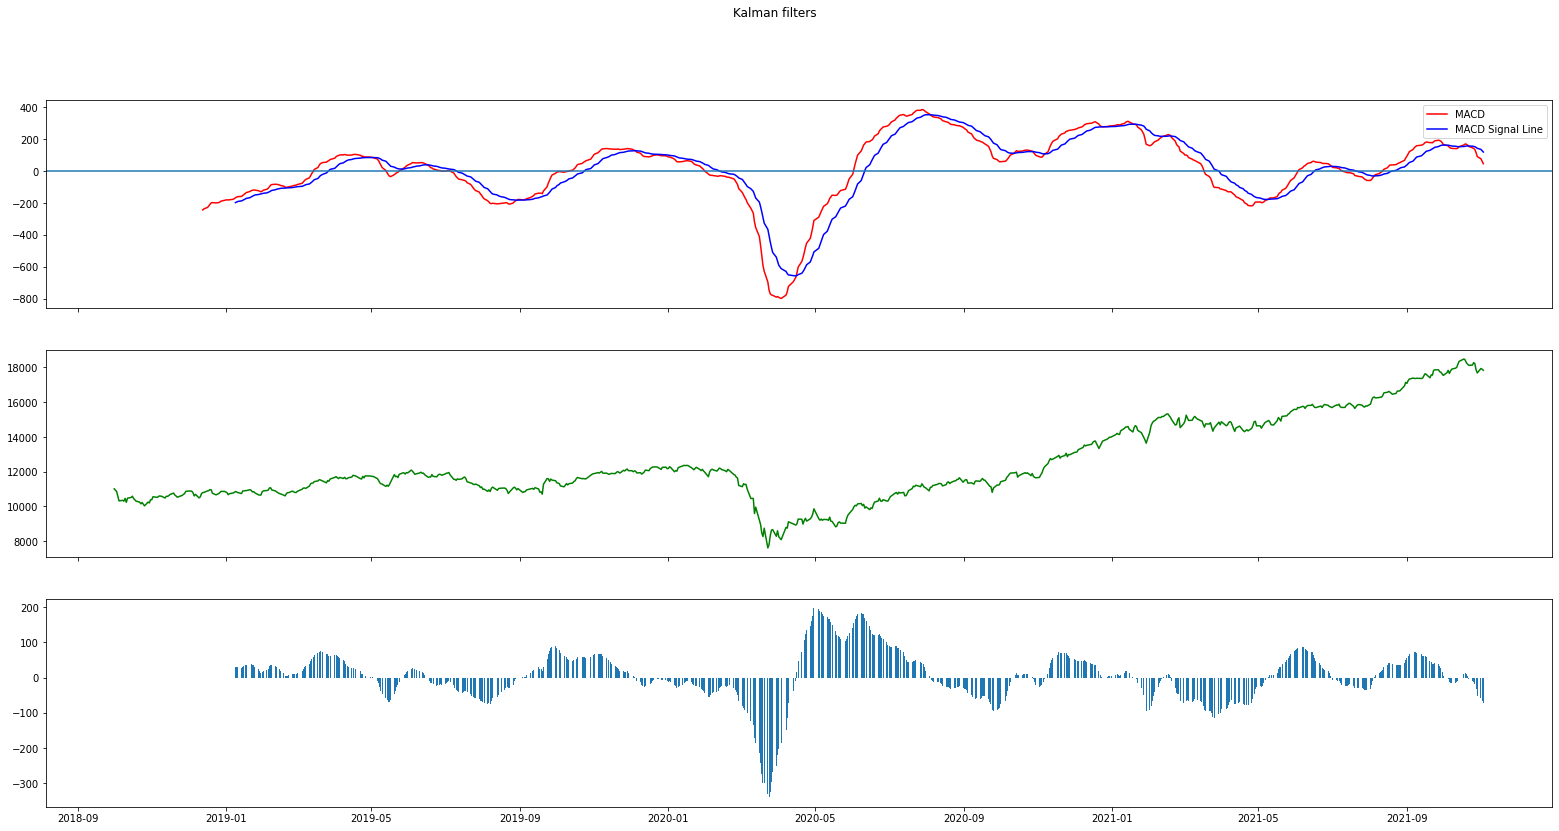

In [137]:
fig, ax = plt.subplots(3,1,figsize=(27,13),linewidth=1,sharex=True)
ax[0].plot(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACD_26_50_18'][-1000:],'r', label='MACD')
ax[0].plot(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACDs_26_50_18'][-1000:],'b', label='MACD Signal Line')
ax[2].bar(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACDh_26_50_18'][-1000:], label='MACD Signal Line')
ax[1].plot(nifty_df.loc[:, :].index[-1000:], nifty_df.loc[:, 'Close'][-1000:],'g', label='NH moving avg 50 days')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Kalman filters')
ax[0].axhline(y=0)
ax[0].legend()
plt.show()


In [ ]:
nifty['signals']=0

for i in range(len(df)):
  if nifty['MACD_26_50_18'].iloc[i]>nifty['MACDs_26_50_18'].iloc[i] and nifty['MACD_26_50_18'].iloc[i-1]<nifty['MACDs_26_50_18'].iloc[i-1]:
    nifty['signals'].iloc[i]=1
  elif nifty['MACD_26_50_18'].iloc[i]<nifty['MACDs_26_50_18'].iloc[i] and nifty['MACD_26_50_18'].iloc[i-1]>nifty['MACDs_26_50_18'].iloc[i-1]:
    nifty['signals'].iloc[i]=-1  
 

In [139]:
nifty['signals_zeroline']=np.where(nifty['MACD_26_50_18']>0,1,-1)

In [140]:
nifty['sum']=nifty['signals']+nifty['signals_zeroline']

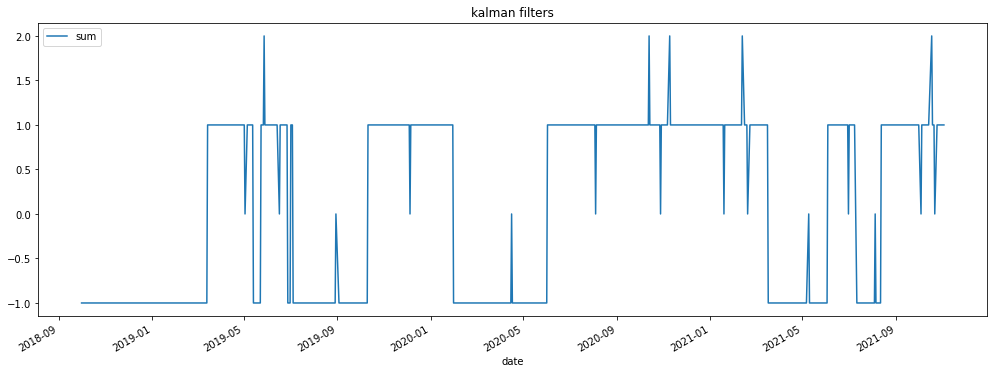

In [141]:
nifty['sum'].plot(kind='line',figsize=(17,6),legend=True,title='kalman filters');

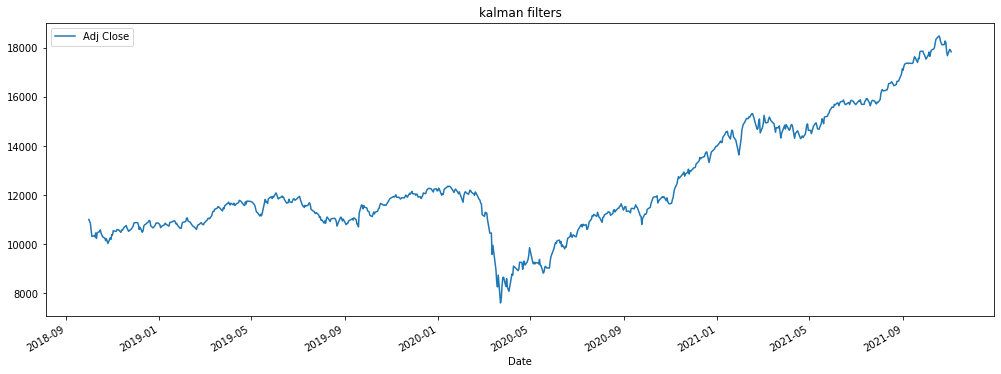

In [142]:
df['Adj Close'].plot(kind='line',figsize=(17,6),legend=True,title='kalman filters');

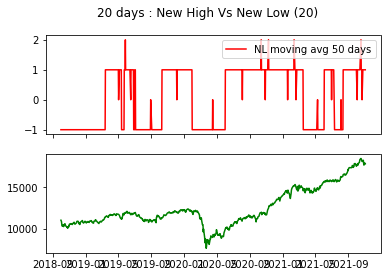

In [143]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'sum'],'r', label='NL moving avg 50 days')
ax[1].plot(df.loc[:, :].index, df.loc[:, 'Adj Close'],'g', label='NH moving avg 50 days')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('20 days : New High Vs New Low (20)')
ax[0].legend()
plt.show()


In [144]:
nifty['sum']=np.where(nifty['sum']>=0,1,-1)

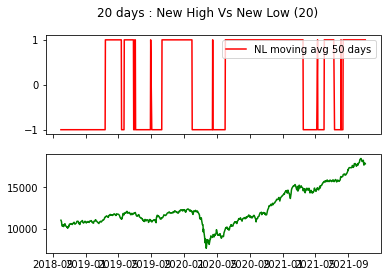

In [145]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'sum'],'r', label='NL moving avg 50 days')
ax[1].plot(df.loc[:, :].index, df.loc[:, 'Adj Close'],'g', label='NH moving avg 50 days')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('20 days : New High Vs New Low (20)')
ax[0].legend()
plt.show()


In [146]:
nifty.tail(2)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_26_50_18,MACDh_26_50_18,MACDs_26_50_18,signals,signals_zeroline,sum
date,,,,,,,,,,,
2021-11-02,2048.066927,2434.859617,263.565358,2566.642296,2303.076938,61.444287,-65.723861,127.168148,0,1,1
2021-11-03,1968.532915,2410.973935,283.380688,2552.664279,2269.283591,45.304833,-73.246123,118.550957,0,1,1


In [147]:
nifty['sum'].to_csv('kalman.csv')